# 3D Quasidynamic earthquake cycle modelling. First steps: a square fault in a full space.

I've been working to get functioning 3D quasidynamic earthquake cycle simulation set up for the last month. It's been an interesting puzzle working through some of the bugs and misunderstandings that have cropped up and I just figured I'd share the story.

During this process, I've read through a lot of the literature on quasidynamic rupture modeling. I've also read a bit about fully dynamic modeling, because it has many of the same complexities when simulating through multiple earthquake cycles! But, the two main sources that I returned to again and again are:

* Lapusta and Liu, *Three-dimensional boundary integral modeling of spontaneous earthquake sequences and aseismic slip*, 2009.
* Erickson and Dunham, *An efficient numerical method for earthquake cycles in heterogeneous media: Alternating sub-basin and surface-rupturing events on faults crossing a sedimentary basin*, 2014.

The Lapusta and Liu paper goes into substantial and directly useful detail on their implementation. As a complement, the Erickson and Dunham paper is nice because it's focused on a finite difference formulation that is in the time and space domain rather than the Fourier domain setting of the Lapusta and Liu paper. My boundary element method (BEM) implementation is also a time and space domain implementation. 

For an intro to the type of problems I'm solving here, checking out [my post on doing a similar 1D "spring-block-slider" model](http://tbenthompson.com/post/block_slider/). The difference is that, here, I'm modeling a fault surface in 3D domain, rather than a point contact in a 1D domain. That adds a lot more complexity to the implementation and . Primarily, doing this in 3D requires an "elastic solver", that will take the current total slip on the fault surface, any other non-fault boundary conditions, and return the traction on the fault surface. As I mentioned in the 1D post, at a high level, the problem is a simple feedback where I loop:

```
while not done:
    slip += velocity * dt
    traction = elastic_solver(slip)
    velocity = rate_state_solver(traction)
```

However, instead of the simple forward Euler method, I'm using a Runge-Kutta (4,5) method to automatically use the largest accurate time step.

# Slip vs Slip-deficit

This is a critical distinction. When calculating the traction on the fault surface, what we care about is the relative motion of the fault with respect to its surroundings. 

# Failure to impose continuity between adjacent elements.

If there is a discontinuity in slip between two adjacent elements, a stress singularity arises at the boundary between those elements. Infinite stress then passes through the friction law, and fundamentally, results in infinite slip. That's no good. So, imposing slip continuity is essential to having reasonable behavior. And it makes fundamental physical sense too. It's unlikely that large voids are forming deep in the Earth.

This is not a problem for most other quasidynamic earthquake modeling software. If you are using the Fourier domain formulation, you get slip continuity for free by virtue of each Fourier component being continuous in space and thus the sum of those components also being continuous. On the other hand, most Okada-dislocation based approaches (e.g. [QDyn](https://github.com/ydluo/qdyn)) evaluate the stress at the centers of elements. Thus, although the model has stress singularities, the stress is never evaluated in a singular region and the problem is partially avoided. On the other hand, I'm curious how the existence of those singularities affects the final results. In general, I believe the linear (or higher order) slip interpolation that I am using on element is better for this set of problems because it allows continuity.

# Inability to trigger ruptures. 

If I initialize the model with zero slip and a initial steady state parameter, and have $a-b < 0$ everywhere, I initially expected that the model would produce ruptures. Surprisingly, that did not happen. The slip rate evolved 



In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import numpy as np
import tectosaur.mesh.mesh_gen

from scipy.integrate import RK45
from scipy.optimize import fsolve
from qd_helpers import *

Define the material, frictional, mesh and boundary condition parameters.

The parameters in `tectosaur_cfg` determine how the integration and evaluating of the integral equations are done. I'll get into the details of Tectosaur some time in the future. For the moment, just trust that Tectosaur does actually solve linear elastic boundary value problems. It's been around the block and has been tested thoroughly, especially for the type of dislocation problems I'm solving here.

In [2]:
n_fault = 100
L = 8000
W = 8000
m = tectosaur.mesh.mesh_gen.make_rect(n_fault, n_fault, [
    [-L, 0, W], [-L, 0, -W],
    [L, 0, -W], [L, 0, W]
])
qdm = QDMeshData(m)

qd_cfg = dict(
    # Material properties
    sm = 2e10,          # Shear modulus (Pa)
    pr = 0.25,          # Poisson ratio 
    density = 2670,     # rock density (kg/m^3)

    # Frictional properties
    Dc = 0.012,         # state evolution length scale (m)
    f0 = 0.6,           # baseline coefficient of friction
    V0 = 1e-6,          # when V = V0, f = f0, V is (m/s)

    # Boundary conditions
    plate_rate = 1e-9,  # (m/s), equivalent to ~31.5 mm/yr
    
    # This is only necessary because this is a full space model and there's no concept of depth or gravity
    additional_normal_stress = 50e6, 
    
    tectosaur_cfg = dict(
        quad_mass_order = 4,       
        quad_vertadj_order = 8,
        quad_far_order = 3,
        quad_near_order = 5,
        quad_near_threshold = 2.5,
        float_type = np.float32,
        use_fmm = False,
        fmm_order = 150,
        fmm_mac = 3.0,
        pts_per_cell = 450,
        log_level = logging.INFO
    )
)
qd_cfg['cs'] = np.sqrt(qd_cfg['sm'] / qd_cfg['density'])# Shear wave speed (m/s)
qd_cfg['eta'] = qd_cfg['sm'] / (2 * qd_cfg['cs'])       # The radiation damping coefficient (kg / (m^2 * s))

In [3]:
dof_pts = m[0][m[1]].reshape((-1,3))

a = np.ones(dof_pts.shape[0]) * 0.010
b = np.ones_like(a) * 0.015
qd_cfg['a'] = a
qd_cfg['b'] = b
#plot_fields(qdm.m, np.vstack((qd_cfg['a'], qd_cfg['b'], qd_cfg['a'] - qd_cfg['b'], qd_cfg['a'] - qd_cfg['b'] < 0)).T)

Check that the "process zone" and $k_{crit}$ are good. See section 6 in Erickson et al 2014

In [4]:
mesh_L = np.max(np.sqrt(np.linalg.norm(qdm.unscaled_tri_normals, axis = 1)))
Lb = qd_cfg['sm'] * qd_cfg['Dc'] / (qd_cfg['additional_normal_stress'] * qd_cfg['b'])
hstar = (np.pi * qd_cfg['sm'] * qd_cfg['Dc']) / (qd_cfg['additional_normal_stress'] * (qd_cfg['b'] - qd_cfg['a']))

hstarRA = (2.0 / np.pi) * qd_cfg['sm'] * qd_cfg['b'] * qd_cfg['Dc'] / ((qd_cfg['b'] - qd_cfg['a']) ** 2 * qd_cfg['additional_normal_stress'])
hstarRA3D = np.pi ** 2 / 4.0 * hstarRA
# all_fields = np.vstack((Lb, hstar, np.ones_like(hstar) * mesh_L)).T
# plot_fields(qdm.m, all_fields)
print('hstar (2d antiplane, erickson and dunham 2014)', np.min(np.abs(hstar)))
print('hstar_RA (2d antiplane, rubin and ampuero 2005)', np.min(np.abs(hstarRA)))
print('hstar_RA3D (3d strike slip, lapusta and liu 2009)', np.min(np.abs(hstarRA3D)))
print('cohesive zone length scale', np.min(Lb))
print('mesh length scale', mesh_L)

hstar (2d antiplane, erickson and dunham 2014) 3015.9289474462016
hstar_RA (2d antiplane, rubin and ampuero 2005) 1833.4649444186348
hstar_RA3D (3d strike slip, lapusta and liu 2009) 4523.893421169303
cohesive zone length scale 320.0
mesh length scale 161.6161616161644


In [5]:
#traction_to_slip = get_traction_to_slip(qdm, qd_cfg)
slip_to_traction = get_slip_to_traction(qdm, qd_cfg)

[4752:INFO:tectosaur.util.cuda]
    Initialized CUDA on gpu: 0


In [6]:
derivs = make_qd_derivs(qdm, qd_cfg, slip_to_traction)

In [7]:
initial_slip = np.zeros(qdm.m.n_dofs())
initial_state = np.ones(qdm.m.tris.shape[0] * 3)
initial_conditions = np.concatenate((initial_slip, initial_state))
integrator = RK45(derivs, 0, initial_conditions, 1e20, atol = 1e-5, rtol = 1e-5)

In [8]:
# t = integrator.t
# y = integrator.y
# slip, state = separate_slip_state(y)
# slip_deficit = get_slip_deficit(qdm, qd_cfg, t, slip)
# traction = slip_to_traction(slip_deficit)
# V = rate_state_solve(qdm, qd_cfg, traction, state)
# dstatedt = state_evolution(qdm, qd_cfg, V, state)

# plot_fields(qdm.m, slip)
# plot_fields(qdm.m, slip_deficit)
# plot_fields(qdm.m, traction)
# plot_fields(qdm.m, np.log10(np.abs(V) + 1e-40))
# plot_fields(qdm.m, dstatedt)

In [ ]:
from tectosaur.util.timer import Timer
from IPython.display import clear_output
#h_t = []
#h_y = []
siay = 60 * 60 * 24 * 365.25
for i in range(10000):
    assert(integrator.step() == None)
    h_t.append(integrator.t)
    h_y.append(integrator.y.copy())
    clear_output()
    print(i, integrator.t / siay)
    if len(h_t) > 1:
        dt = h_t[-1] - h_t[-2]
        dx = (L * 2) / (n_fault - 1)
        dt_dynamic = mesh_L / qd_cfg['cs'] / 3.0
        dt_evol = 0.5 * qd_cfg['Dc'] / qdm.max_V
        print('time step vs lapusta', dt, dt_evol, dt_dynamic)
    #plot_setting(integrator.t, integrator.y, qdm, qd_cfg, slip_to_traction)
    if i % 500 == 0:
        np.save('results.npy', np.array([qdm.m, qd_cfg, h_t, h_y], dtype = np.object))

830 433.1787486065046
time step vs lapusta 1491.209285736084 3596.3169893418785 0.019683583468224027


slip


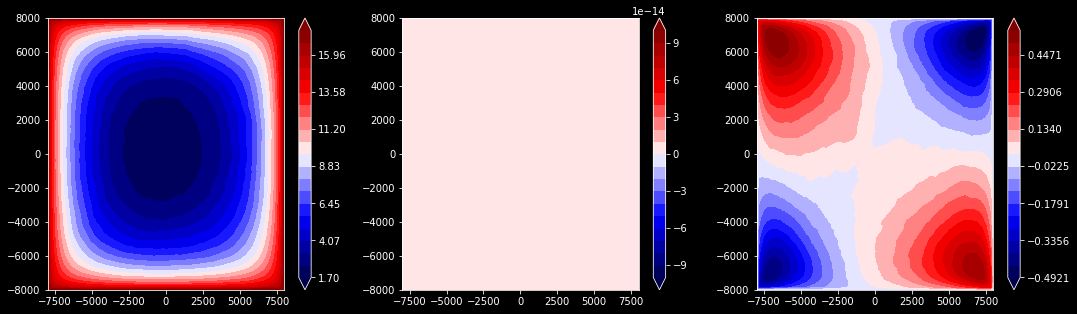

V


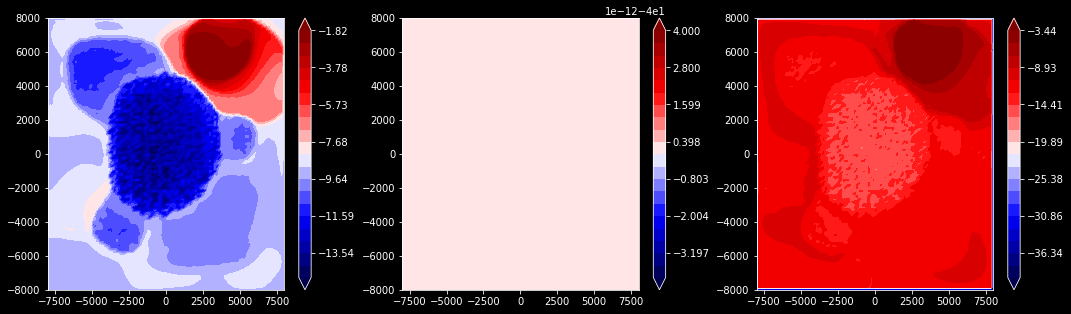

traction


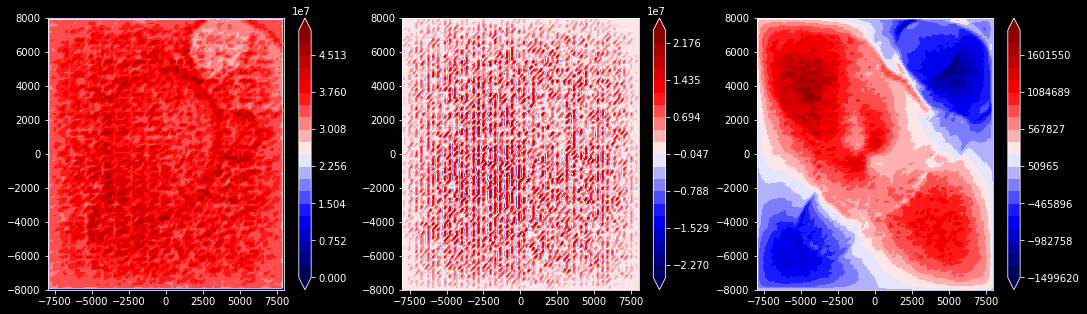

state


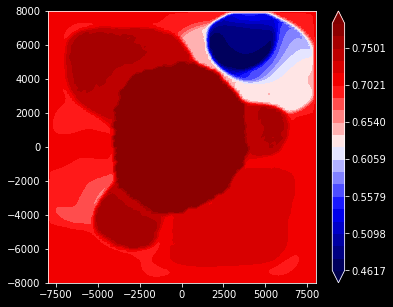

In [17]:
plot_setting(integrator.t, integrator.y, qdm, qd_cfg, slip_to_traction)